# Redcard Exploratory Data Analysis

This dataset is taken from a fantastic paper that looks to see how analytical choices made by different data science teams on the same dataset in an attempt to answer the same research question affect the final outcome.

[Many analysts, one dataset: Making transparent how variations in analytical choices affect results](https://osf.io/gvm2z/)

The data can be found [here](https://osf.io/47tnc/).



## The Task

Do an Exploratory Data Analysis on the redcard dataset. Keeping in mind the question is the following: **Are soccer referees more likely to give red cards to dark-skin-toned players than light-skin-toned players?**

- Before plotting/joining/doing something, have a question or hypothesis that you want to investigate
- Draw a plot of what you want to see on paper to sketch the idea
- Write it down, then make the plan on how to get there
- How do you know you aren't fooling yourself
- What else can I check if this is actually true?
- What evidence could there be that it's wrong?


In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

from __future__ import absolute_import, division, print_function
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib.pyplot import GridSpec
import seaborn as sns
import numpy as np
import pandas as pd
import os, sys
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')
sns.set_context("poster", font_scale=1.3)

import missingno as msno
import pandas_profiling

from sklearn.datasets import make_blobs
import time

## About the Data

> The dataset is available as a list with 146,028 dyads of players and referees and includes details from players, details from referees and details regarding the interactions of player-referees. A summary of the variables of interest can be seen below. A detailed description of all variables included can be seen in the README file on the project website. 

> From a company for sports statistics, we obtained data and profile photos from all soccer players (N = 2,053) playing in the first male divisions of England, Germany, France and Spain in the 2012-2013 season and all referees (N = 3,147) that these players played under in their professional career (see Figure 1). We created a dataset of playerâreferee dyads including the number of matches players and referees encountered each other and our dependent variable, the number of red cards given to a player by a particular referee throughout all matches the two encountered each other.

> -- https://docs.google.com/document/d/1uCF5wmbcL90qvrk_J27fWAvDcDNrO9o_APkicwRkOKc/edit


| Variable Name: | Variable Description: | 
| -- | -- | 
| playerShort | short player ID | 
| player | player name | 
| club | player club | 
| leagueCountry | country of player club (England, Germany, France, and Spain) | 
| height | player height (in cm) | 
| weight | player weight (in kg) | 
| position | player position | 
| games | number of games in the player-referee dyad | 
| goals | number of goals in the player-referee dyad | 
| yellowCards | number of yellow cards player received from the referee | 
| yellowReds | number of yellow-red cards player received from the referee | 
| redCards | number of red cards player received from the referee | 
| photoID | ID of player photo (if available) | 
| rater1 | skin rating of photo by rater 1 | 
| rater2 | skin rating of photo by rater 2 | 
| refNum | unique referee ID number (referee name removed for anonymizing purposes) | 
| refCountry | unique referee country ID number | 
| meanIAT | mean implicit bias score (using the race IAT) for referee country | 
| nIAT | sample size for race IAT in that particular country | 
| seIAT | standard error for mean estimate of race IAT   | 
| meanExp | mean explicit bias score (using a racial thermometer task) for referee country | 
| nExp | sample size for explicit bias in that particular country | 
| seExp |  standard error for mean estimate of explicit bias measure | 



In [2]:
# Uncomment one of the following lines and run the cell:

# df = pd.read_csv("redcard.csv.gz", compression='gzip')
# df = pd.read_csv("https://github.com/cmawer/pycon-2017-eda-tutorial/raw/master/data/redcard/redcard.csv.gz", compression='gzip')

In [3]:
def save_subgroup(dataframe, g_index, subgroup_name, prefix='raw_'):
    save_subgroup_filename = "".join([prefix, subgroup_name, ".csv.gz"])
    dataframe.to_csv(save_subgroup_filename, compression='gzip', encoding='UTF-8')
    test_df = pd.read_csv(save_subgroup_filename, compression='gzip', index_col=g_index, encoding='UTF-8')
    # Test that we recover what we send in
    if dataframe.equals(test_df):
        print("Test-passed: we recover the equivalent subgroup dataframe.")
    else:
        print("Warning -- equivalence test!!! Double-check.")

In [4]:
def load_subgroup(filename, index_col=[0]):
    return pd.read_csv(filename, compression='gzip', index_col=index_col)

In [5]:
clean_players = load_subgroup("cleaned_players.csv.gz")
players = load_subgroup("raw_players.csv.gz", )
countries = load_subgroup("raw_countries.csv.gz")
referees = load_subgroup("raw_referees.csv.gz")
agg_dyads = pd.read_csv("raw_dyads.csv.gz", compression='gzip', index_col=[0, 1])
# tidy_dyads = load_subgroup("cleaned_dyads.csv.gz")
tidy_dyads = pd.read_csv("cleaned_dyads.csv.gz", compression='gzip', index_col=[0, 1])

## Joining and further considerations

In [6]:
!conda install pivottablejs -y

Fetching package metadata .........
Solving package specifications: .

# All requested packages already installed.
# packages in environment at /home/nbcommon/anaconda3_410:
#
pivottablejs              2.7.0                    py35_0  


In [7]:
from pivottablejs import pivot_ui

In [8]:
clean_players = load_subgroup("cleaned_players.csv.gz")

In [9]:
temp = tidy_dyads.reset_index().set_index('playerShort').merge(clean_players, left_index=True, right_index=True)

In [10]:
temp.shape

(373067, 10)

In [11]:
# This does not work on Azure notebooks out of the box
# pivot_ui(temp[['skintoneclass', 'position_agg', 'redcard']], )

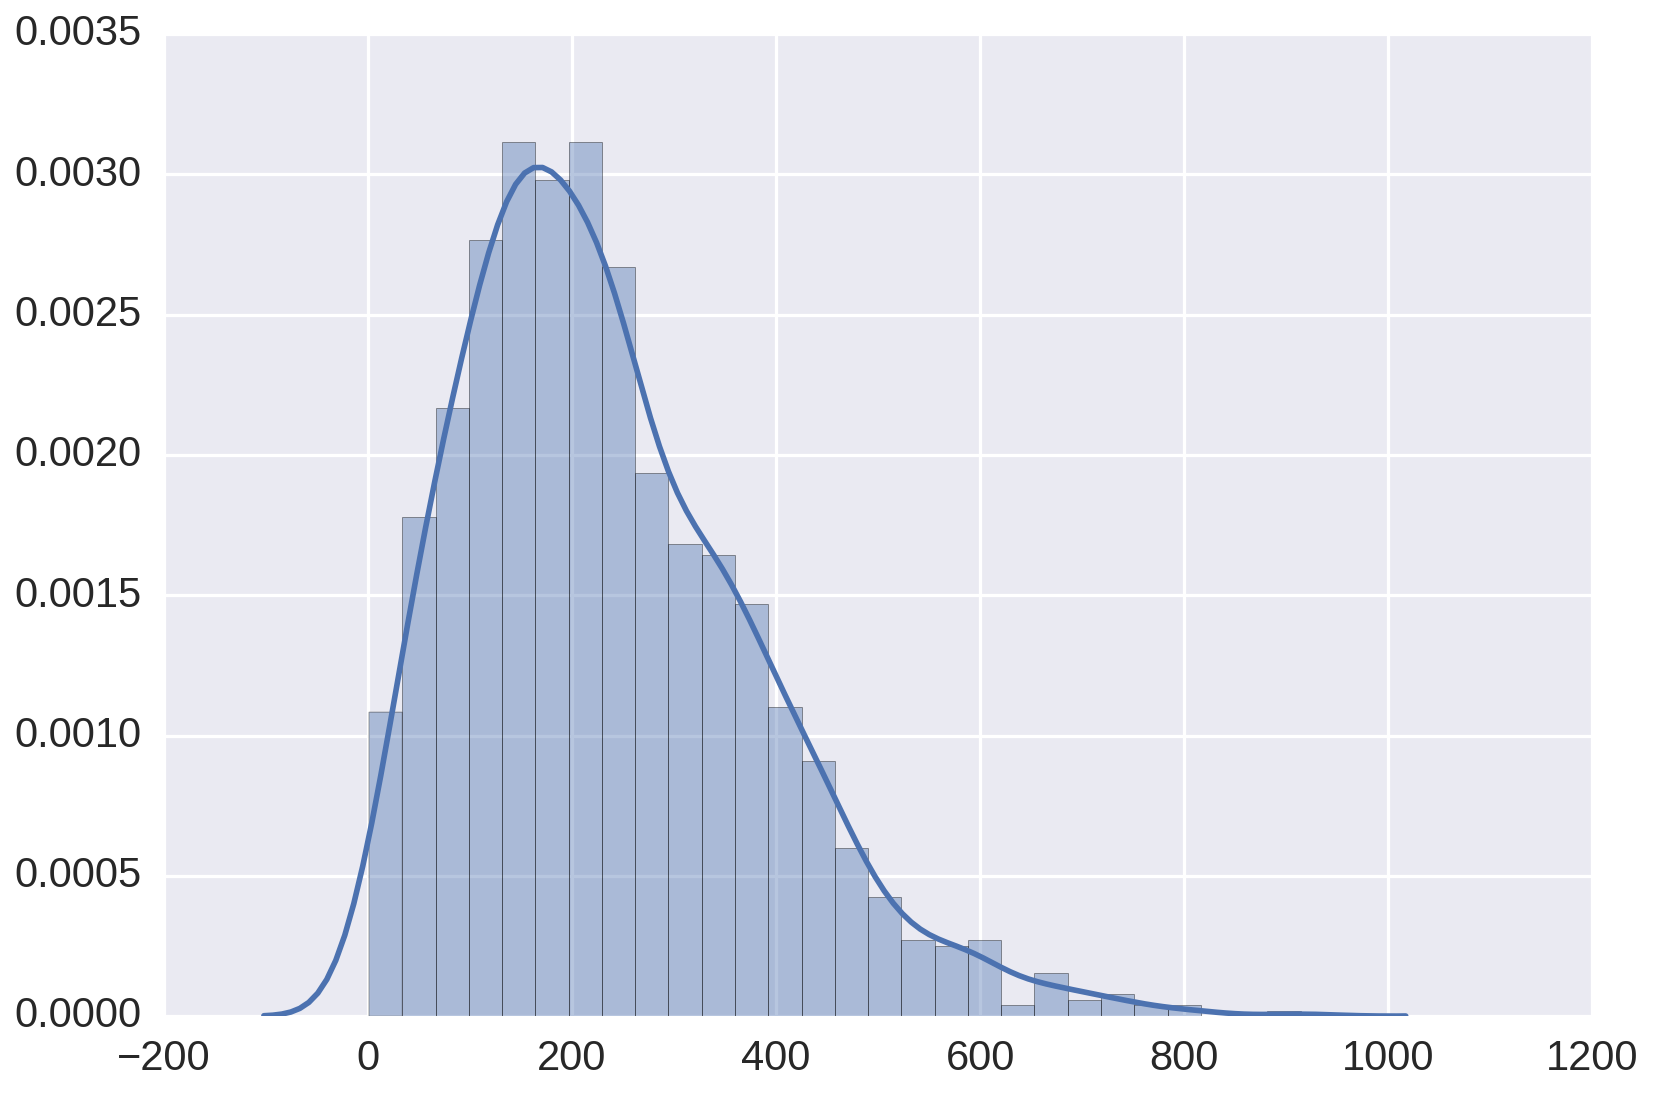

In [12]:
# How many games has each player played in?
games = tidy_dyads.groupby(level=1).count()
sns.distplot(games);

In [13]:
(tidy_dyads.groupby(level=0)
           .count()
           .sort_values('redcard', ascending=False)
           .rename(columns={'redcard':'total games refereed'})).head()

,total games refereed
refNum,
1214,5598
2080,4773
1942,4469
2398,4363
3099,4087


In [14]:
(tidy_dyads.groupby(level=0)
           .sum()
           .sort_values('redcard', ascending=False)
           .rename(columns={'redcard':'total redcards given'})).head()

,total redcards given
refNum,
468,49
432,49
449,47
916,42
2073,36


In [15]:
(tidy_dyads.groupby(level=1)
           .sum()
           .sort_values('redcard', ascending=False)
           .rename(columns={'redcard':'total redcards received'})).head()

,total redcards received
playerShort,
cyril-jeunechamp,19
sergio-ramos,19
gary-medel,16
ballesteros,15
juanfran,15


In [16]:
tidy_dyads.head()

redcard
refNum playerShort                
1      lucas-wilchez             0
2      john-utaka                0
4      aaron-hughes              0
       aleksandar-kolarov        0
       alexander-tettey          0

In [17]:
tidy_dyads.groupby(level=0).size().sort_values(ascending=False)

refNum
1214    5598
2080    4773
1942    4469
2398    4363
3099    4087
933     3901
487     3626
1903    3612
756     3610
88      3560
1646    3541
2902    3466
1811    3450
194     3324
1909    3168
916     3079
2042    3041
1696    3013
2370    2962
449     2956
468     2947
1706    2817
432     2756
2803    2701
1707    2687
641     2655
77      2646
2796    2640
274     2545
1108    2493
        ... 
1837       1
1768       1
2648       1
1775       1
856        1
2677       1
2675       1
853        1
1789       1
348        1
2659       1
2656       1
2651       1
842        1
354        1
1798       1
1833       1
1800       1
1801       1
1802       1
361        1
831        1
2631       1
1827       1
2627       1
825        1
824        1
2620       1
2616       1
1          1
dtype: int64

In [18]:
total_ref_games = tidy_dyads.groupby(level=0).size().sort_values(ascending=False)
total_player_games = tidy_dyads.groupby(level=1).size().sort_values(ascending=False)

In [19]:
total_ref_given = tidy_dyads.groupby(level=0).sum().sort_values(ascending=False,by='redcard')
total_player_received = tidy_dyads.groupby(level=1).sum().sort_values(ascending=False, by='redcard')

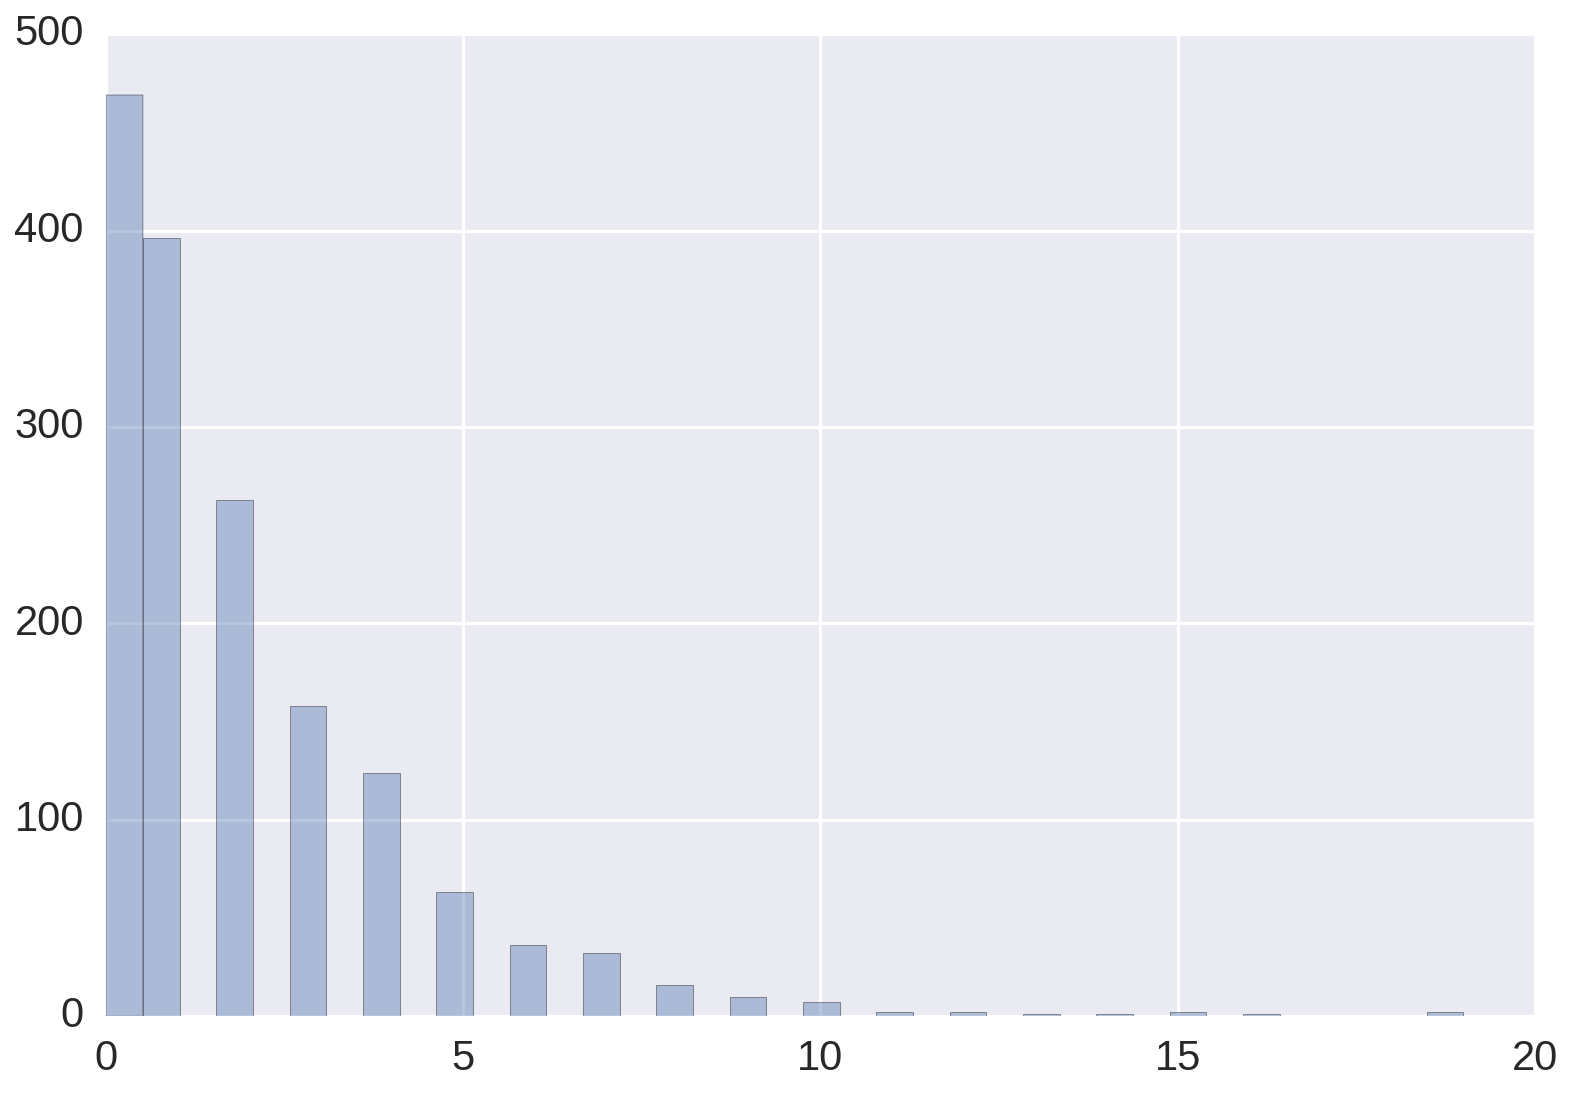

In [20]:
sns.distplot(total_player_received, kde=False);

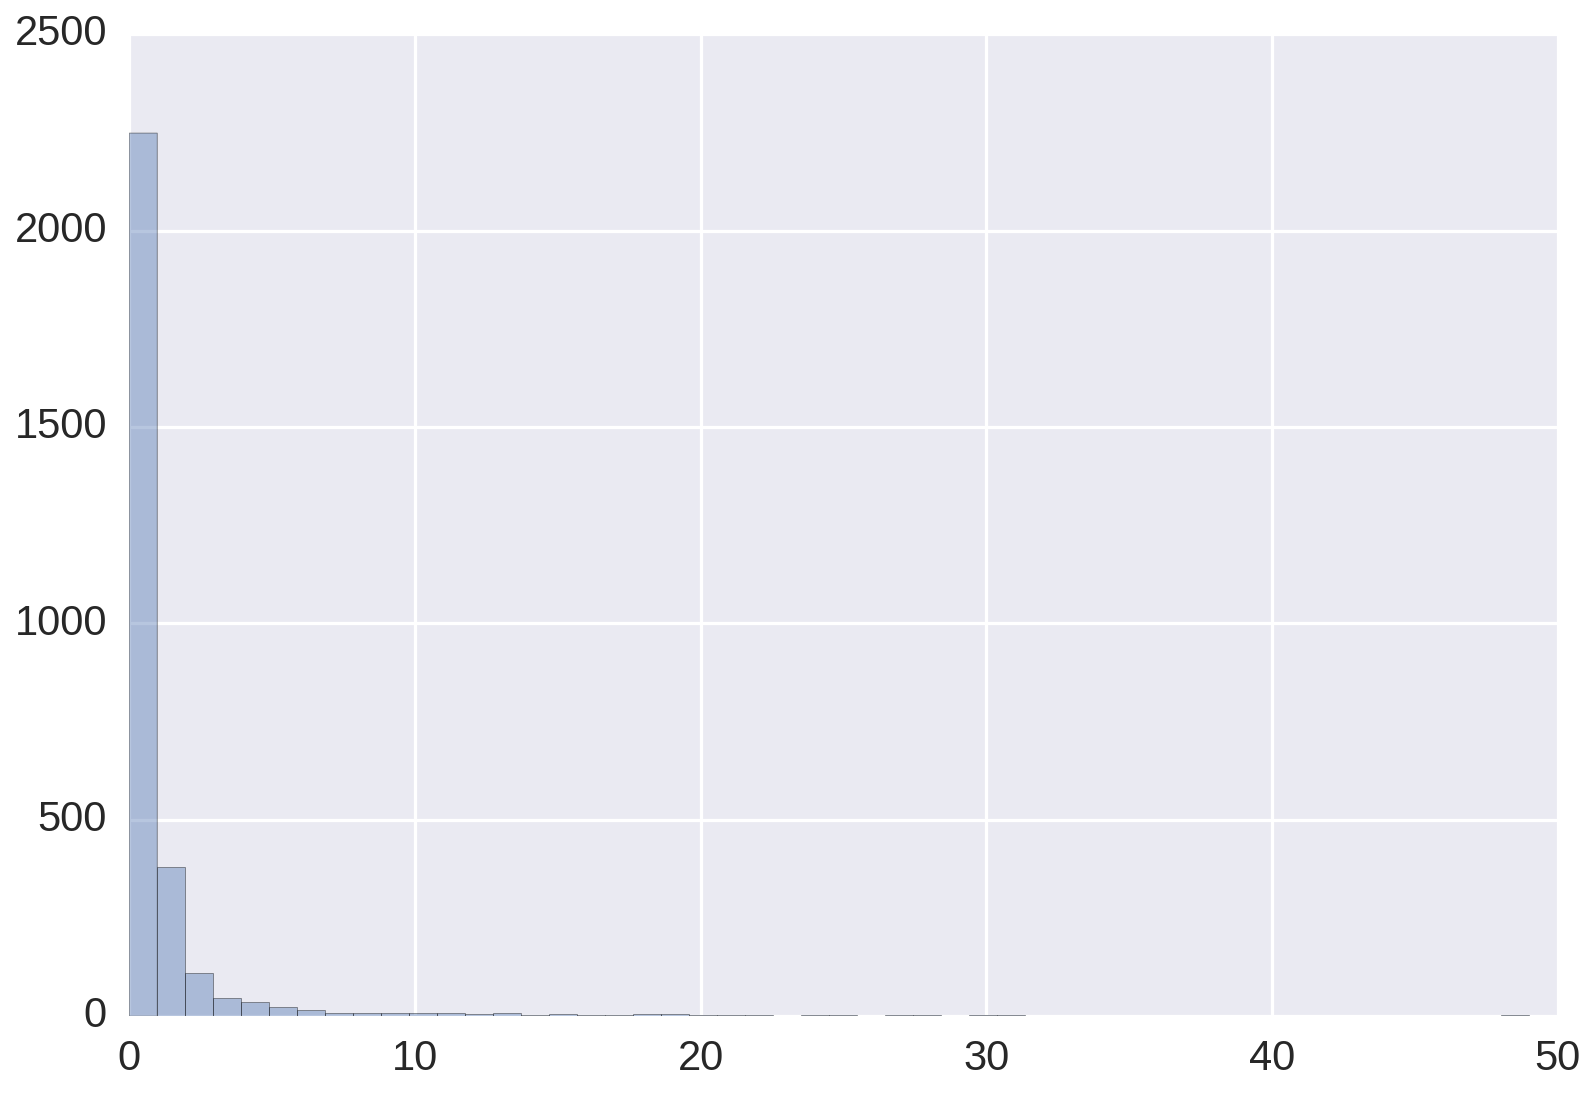

In [21]:
sns.distplot(total_ref_given, kde=False);

In [22]:
tidy_dyads.groupby(level=1).sum().sort_values(ascending=False, by='redcard').head()

,redcard
playerShort,
cyril-jeunechamp,19
sergio-ramos,19
gary-medel,16
ballesteros,15
juanfran,15


In [23]:
tidy_dyads.sum(), tidy_dyads.count(), tidy_dyads.sum()/tidy_dyads.count()

(redcard    3092
 dtype: int64, redcard    373067
 dtype: int64, redcard    0.008288
 dtype: float64)

In [24]:
player_ref_game = (tidy_dyads.reset_index()
                               .set_index('playerShort')
                                       .merge(clean_players,
                                              left_index=True,
                                              right_index=True)
                  )

In [25]:
player_ref_game.head()

,refNum,redcard,height,weight,skintone,position_agg,weightclass,heightclass,skintoneclass,age_years
playerShort,,,,,,,,,,
aaron-hughes,4,0,182.0,71.0,0.125,Defense,low_weight,mid_height,"[0, 0.125]",33.149897
aaron-hughes,66,0,182.0,71.0,0.125,Defense,low_weight,mid_height,"[0, 0.125]",33.149897
aaron-hughes,77,0,182.0,71.0,0.125,Defense,low_weight,mid_height,"[0, 0.125]",33.149897
aaron-hughes,77,0,182.0,71.0,0.125,Defense,low_weight,mid_height,"[0, 0.125]",33.149897
aaron-hughes,77,0,182.0,71.0,0.125,Defense,low_weight,mid_height,"[0, 0.125]",33.149897


In [26]:
player_ref_game.shape

(373067, 10)

In [27]:
bootstrap = pd.concat([player_ref_game.sample(replace=True, 
                                              n=10000).groupby('skintone').mean() 
                       for _ in range(100)])

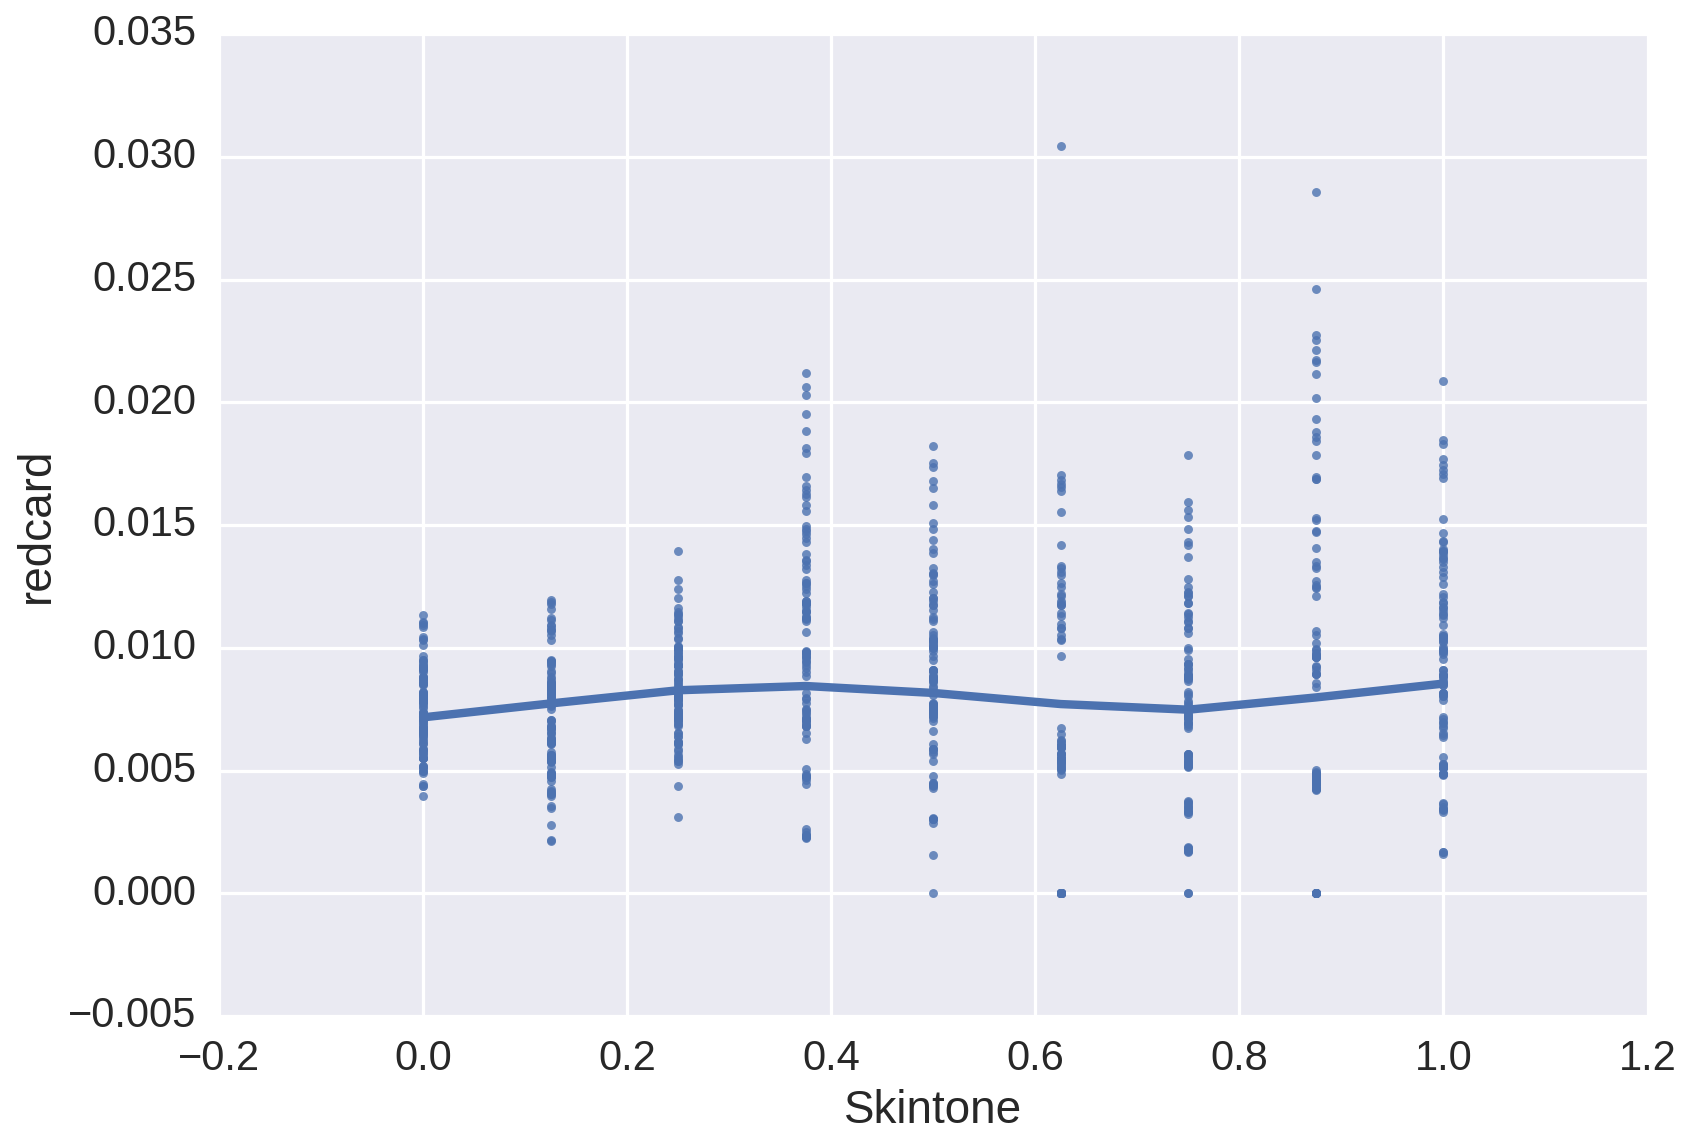

In [28]:
ax = sns.regplot(bootstrap.index.values,
            y='redcard',
            data=bootstrap,
            lowess=True,)
ax.set_xlabel("Skintone");